In [5]:
import logging
from typing import Callable, Literal, Optional, Union

import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.optimize import minimize

from bwlogger import StyleAdapter
import argparse
import logging
from pathlib import Path
from typing import Literal, Optional, Union, Any

import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

from aamalha.utils.performance import Performance
from bwbbgdl import GoGet
from bwlogger import StyleAdapter, basic_setup
from bwutils import TODAY, Date

from portfolio.construction import calculate_weights

from utils import (
    get_available_trackers,
    load_trackers,
    correlation_to_distance,
    cap_long_only_weights,
)
from plot import plot_results, scatter_plot, stacked_bar_plot

In [2]:
OUTPUT_FOLDER = Path(r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\resultados")
INVERSE_QUOTED = (
    "JPY",
    "HKD",
    "PHP",
    "CHF",
    "CZK",
    "CAD",
    "CLP",
    "DKK",
    "NOK",
    "SEK",
    "RUB",
    "BRL",
    "MXN",
    "HUF",
    "PLN",
    "TRY",
    "ILS",
    "INR",
    "TWD",
    "KRW",
    "IDR",
    "CNH",
    "CNY",
    "SGD",
    "ZAR",
    "THB",
    "COP",
    "MYR",
    "HKD",
)

## Load Data

### Bloomberg Data

In [ ]:
path = r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\Projeto Asset Allocation.xlsx"
df_base = pd.read_excel(path, index_col=0, skiprows=1, sheet_name="base_values")
df_base

### Auxiliar Table

In [ ]:
df_base_aux = pd.read_excel(path, index_col=0, usecols="A:F", sheet_name="aux")
df_base_aux

### Trackers

In [ ]:
ONSHORE_BENHCMARK = "BZACCETP Index"
OFFSHORE_BENHCMARK = "G0O1 Index"

list_trackers = []
for ticker in df_base_aux[df_base_aux["include"]].index:
    alias = df_base_aux.loc[ticker, "alias"]
    curncy = df_base_aux.loc[ticker, "currency"]
    excess_index = df_base_aux.loc[ticker, "excess_index"]
    s_total_return = df_base[ticker].copy().dropna()

    if curncy == "BRL":
        s_benchmark_return = df_base[ONSHORE_BENHCMARK]
    else: 
        s_benchmark_return = df_base[OFFSHORE_BENHCMARK]
        if curncy != "USD":
            s_total_return_local_ccy = s_total_return
            curncy = "EUR"
            ccy = df_base[f"USD{curncy} Curncy"].copy()
            if curncy in INVERSE_QUOTED:
                ccy = 1 / ccy
            s_total_return_usd = (s_total_return_local_ccy.diff(1) * ccy).dropna()
            s_total_return_usd = s_total_return_usd.reindex(s_total_return_local_ccy.index)
            s_total_return_usd.iloc[0] = (
                s_total_return_local_ccy.iloc[0] * ccy[s_total_return_usd.index[0]]
            )
            s_total_return_usd = s_total_return_usd.cumsum()
            s_total_return = s_total_return_usd.copy()

    if excess_index:
        s_excess_return = s_benchmark_return*0 + 1
    s_excess_return = (s_total_return / s_benchmark_return).dropna()
    s_excess_return.name = alias
    s_excess_return = s_excess_return / s_excess_return.iloc[0] * 100
    list_trackers.append(s_excess_return)

df_trackers = pd.concat(list_trackers, axis=1)

df_trackers.to_excel(OUTPUT_FOLDER.joinpath("trackers_excess_returns.xlsx"))
df_trackers.plot()

## Analysis

### Performance Trackers

In [ ]:
perf_trackers = Performance(df_trackers)
df_performance = perf_trackers.table.T.copy()
df_performance.index.name = "Tracker"
df_performance.to_excel(OUTPUT_FOLDER.joinpath("performance_trackers.xlsx"))

### Correlation

In [ ]:
df_corr = np.log(df_trackers).diff(1).corr().copy()
df_corr.to_excel(OUTPUT_FOLDER.joinpath("full_sample_correlation.xlsx"))

### Dendogram

In [ ]:
linked = linkage(correlation_to_distance(df_corr), "single", optimal_ordering=True)
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(
    linked,
    orientation="right",
    labels=df_corr.columns,
    distance_sort="descending",
    show_leaf_counts=True,
)
plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("Assets")
plt.xlabel("Distance")
plt.savefig(OUTPUT_FOLDER.joinpath("dendrogram.svg"))
plt.show()

## Portfolio Construction

In [ ]:
# def backtest(
#     tracker_df: pd.DataFrame,
#     vol_target: float = 0.2,
#     method_weights: Literal["hrp", "minvar", "ivp", "erc"] = "ivp",
# ) -> pd.DataFrame:
#     vol_equity = vol_target * 2.5
#     vol_non_equity = vol_equity / 4
#     NON_EQUITY = [
#         "Pre-fixados",
#         "Inflação (<5)",
#         "Inflação (>5)",
#         "Commodities",
#         "Treasury 20+ Y TR Index",
#         "HYG TR Index",
#     ]
#     EQUITY = list(set(tracker_df.columns) - set(NON_EQUITY))

#     STARTING_DATA_POINTS = 252 * 3
#     # STARTING_DATA_POINTS = 3000
#     return_days = 21
#     min_data_points = 252
#     # min_data_points = 100

#     backtest = pd.Series(index=tracker_df.index[STARTING_DATA_POINTS + return_days :])
#     backtest.iloc[0] = 100.0

#     starting_trackers = get_available_trackers(
#         tracker_df.iloc[: STARTING_DATA_POINTS + return_days],
#         STARTING_DATA_POINTS,
#     )
#     starting_trackers_equity = list(set(starting_trackers) & set(EQUITY))
#     starting_trackers_non_equity = list(set(starting_trackers) & set(NON_EQUITY))
#     cov_equity = (
#         np.log(tracker_df)[starting_trackers_equity].diff(return_days).cov()
#         * 252
#         / return_days
#     )
#     cov_non_equity = (
#         np.log(tracker_df)[starting_trackers_non_equity].diff(return_days).cov()
#         * 252
#         / return_days
#     )
#     w_equity = calculate_weights(
#         np.log(tracker_df[starting_trackers_equity]).diff(1), method=method_weights
#     )
#     w_non_equity = calculate_weights(
#         np.log(tracker_df[starting_trackers_non_equity]).diff(1), method=method_weights
#     )
#     adj_factor_equity = vol_equity / np.sqrt(w_equity @ cov_equity @ w_equity)
#     adj_factor_non_equity = vol_non_equity / np.sqrt(
#         w_non_equity @ cov_non_equity @ w_non_equity
#     )
#     w = pd.concat(
#         [
#             1 / 4 * adj_factor_equity * w_equity,
#             3 / 4 * adj_factor_non_equity * w_non_equity,
#         ]
#     )
#     q = backtest.iloc[0] * w / tracker_df.iloc[0]

#     for t, tm1 in zip(backtest.index[1:], backtest.index[:-1]):
#         pnl = ((tracker_df.loc[t] - tracker_df.loc[tm1]) * q).sum()
#         backtest[t] = backtest[tm1] + pnl
#         if t.month != tm1.month:
#             # print("Rebalance %s" % t.strftime("%m/%d/%Y"))
#             available_trackers = get_available_trackers(
#                 tracker_df.loc[:t], min_data_points + return_days
#             )
#             available_trackers_equity = list(set(available_trackers) & set(EQUITY))
#             available_trackers_non_equity = list(
#                 set(available_trackers) & set(NON_EQUITY)
#             )
#             # print("Available Trackers %s" % available_trackers)
#             cov_equity = (
#                 np.log(tracker_df.loc[:t][available_trackers_equity])
#                 .diff(return_days)
#                 .cov()
#                 * 252
#                 / return_days
#             )
#             cov_non_equity = (
#                 np.log(tracker_df.loc[:t][available_trackers_non_equity])
#                 .diff(return_days)
#                 .cov()
#                 * 252
#                 / return_days
#             )
#             w_equity = calculate_weights(
#                 np.log(tracker_df.loc[:t][available_trackers_equity]).diff(1),
#                 method=method_weights,
#             )
#             w_non_equity = calculate_weights(
#                 np.log(tracker_df.loc[:t][available_trackers_non_equity]).diff(1),
#                 method=method_weights,
#             )
#             # print(w_equity.index)
#             # print(cov_equity.index)
#             adj_factor_equity = vol_target / np.sqrt(w_equity @ cov_equity @ w_equity)
#             adj_factor_non_equity = vol_target / np.sqrt(
#                 w_non_equity @ cov_non_equity @ w_non_equity
#             )
#             w = pd.concat(
#                 [
#                     1 / 4 * adj_factor_equity * w_equity,
#                     3 / 4 * adj_factor_non_equity * w_non_equity,
#                 ]
#             )
#             q = backtest[tm1] * w / tracker_df.loc[tm1]

#     df_backtest = pd.concat(
#         [tracker_df, backtest.to_frame("assets")],
#         axis=1,
#         join="outer",
#         sort=True,
#     )
#     return df_backtest


# df_backtest = backtest(df_trackers, method_weights="ivp")
# s_portfolio = np.log(df_backtest["assets"].copy()).diff(1).dropna()
# s_ibov = np.log(df_backtest["Ações Brasil"].copy()).diff(1).dropna()


# df_backtest.plot()

In [ ]:
def backtest2(
    tracker_df: pd.DataFrame,
    vol_target: float = 0.2,
    method_weights: Literal["hrp", "minvar", "ivp", "erc"] = "ivp",
    cap: Optional[float] = None, 
) -> tuple[pd.DataFrame, pd.DataFrame]:
    name = f"{method_weights}" + (f"_{cap:.0%}" if cap else "")
    print(name)

    STARTING_DATA_POINTS = 252 * 3
    STARTING_DATA_POINTS = 1305
    return_days = 21
    min_data_points = 252

    backtest = pd.Series(index=tracker_df.index[STARTING_DATA_POINTS + return_days :])
    backtest.iloc[0] = 100.0

    starting_trackers = get_available_trackers(
        tracker_df.iloc[: STARTING_DATA_POINTS + return_days],
        STARTING_DATA_POINTS,
    )
    cov = (
        np.log(tracker_df)[starting_trackers].diff(return_days).cov()
        * 252
        / return_days
    )
    # print(starting_trackers)
    w = calculate_weights(
        np.log(tracker_df[starting_trackers]).diff(1),
        method=method_weights,
        long_only=True,
    )
    w = cap_long_only_weights(w, cap=cap)
    # print(w.to_string())
    adj_factor = vol_target / np.sqrt(w @ cov @ w)
    w = adj_factor * w
    q = backtest.iloc[0] * w / tracker_df.iloc[0]
    dict_positions = {}
    dict_positions[backtest.index[0]] = q.to_dict()

    for t, tm1 in zip(backtest.index[1:], backtest.index[:-1]):
        pnl = ((tracker_df.loc[t] - tracker_df.loc[tm1]) * q).sum()
        dict_positions[t] = ((tracker_df.loc[t] / tracker_df.loc[tm1]) * q).to_dict()
        backtest[t] = backtest[tm1] + pnl
        if t.month != tm1.month:
            # print("Rebalance %s" % t.strftime("%m/%d/%Y"))
            available_trackers = get_available_trackers(
                tracker_df.loc[:t], min_data_points + return_days
            )
            # print("Available Trackers %s" % available_trackers)
            cov = (
                np.log(tracker_df.loc[:t][available_trackers]).diff(return_days).cov()
                * 252
                / return_days
            )
            w = calculate_weights(
                np.log(tracker_df.loc[:t][available_trackers]).diff(1),
                method=method_weights,
                long_only=True,
            )
            w = cap_long_only_weights(w, cap=cap)
            # print(w.to_string())
            adj_factor = vol_target / np.sqrt(w @ cov @ w)
            w = adj_factor * w
            q = backtest[tm1] * w / tracker_df.loc[tm1]

    df_backtest = pd.concat(
        [tracker_df, backtest.to_frame(name)],
        axis=1,
        join="outer",
        sort=True,
    )
    df_backtest.name = method_weights
    df_positions = pd.DataFrame(dict_positions).T
    df_positions.name = name
    return df_backtest.copy(), df_positions.copy()


list_backtest = []
list_positions = []
methods_wegiths = ["hrp", "minvar", "ivp", "erc"]
for method_weights in methods_wegiths:
    for cap in [n/10 for n in range(7, 1, -1)]:
        try:
            df_backtest, df_positions = backtest2(
                df_trackers, method_weights=method_weights, cap=cap
            )
            list_backtest.append(df_backtest.iloc[:, -1].copy())
            list_positions.append(df_positions.copy())
        except:
            print("Error: %s" % method_weights)
            pass

df_backtest = pd.concat(
    df_trackers,
    list_backtest,
    axis=1,
)
# s_portfolio = np.log(df_backtest["assets"].copy()).diff(1).dropna()
# s_ibov = np.log(df_backtest["Ações Brasil"].copy()).diff(1).dropna()


df_backtest.plot()

In [ ]:
backtest2(df_trackers, method_weights="ivp", cap=None)[1].name

In [ ]:
for df_position in zip(list_positions, ):
    df_position.name = f"{method_weights}_{cap:.0%}"
    df_position.plot(kind="line")
    plt.title(df_position.name)

In [ ]:
df_ivp = list_positions[2]
df_weights_plot = df_ivp.divide(df_backtest["ivp"].reindex(df_ivp.index), axis=0)
df_weights_plot[df_weights_plot.sum().sort_values(ascending=False).index].plot(kind="area", stacked=True)

In [ ]:
df_weights_plot

In [ ]:
df_backtest = pd.read_excel(OUTPUT_FOLDER.joinpath("backtest.xlsx"), index_col=0)

In [ ]:
df_backtest.columns

In [ ]:
# perf_trackers = Performance(df_backtest.loc[df_backtest["hrp_20%"].dropna().index[0] :])
df_performance = perf_trackers.table.T.copy()
df_performance.index.name = "Tracker"
df_performance.sort_values("Sharpe", ascending=False).to_excel(OUTPUT_FOLDER.joinpath("performance_table_backtest.xlsx"))

In [ ]:
perf_trackers.plot_drawdowns("ivp", show_chart=True)

In [ ]:
perf_trackers.plot_underwater("ivp", show_chart=True)

### Scatter Plot (vs IBOV)

In [ ]:
scatter_plot(
    x_values=s_ibov,
    y_values=s_portfolio,
    yaxis_title="Portfolio Returns",
    xaxis_title="IBOV Returns",
    plot_title="Scatter Plot of Portfolio Returns vs. IBOV Returns",
    fit_type="linear",
    output_path=OUTPUT_FOLDER.joinpath("scatter_plot_portvolio_vs_ibov.svg"),
)

In [ ]:
df_weights = pd.concat(
    [
        calculate_weights(np.log(df_trackers).diff(5), method, long_only=True)
        for method in ["hrp", "minvar", "ivp", "erc"]
    ],
    axis=1,
)

In [ ]:
df_weights.T.plot(kind="bar", stacked=True)

plt.ylabel("Weight")
plt.title("Stacked Bar Chart Summing to 100%")
plt.show()

### Chart Allocation History

C:\Users\pcampos\AppData\Local\Temp\ipykernel_20456\951339785.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df_weights.columns = df_weights.columns.str.replace(".1", "")


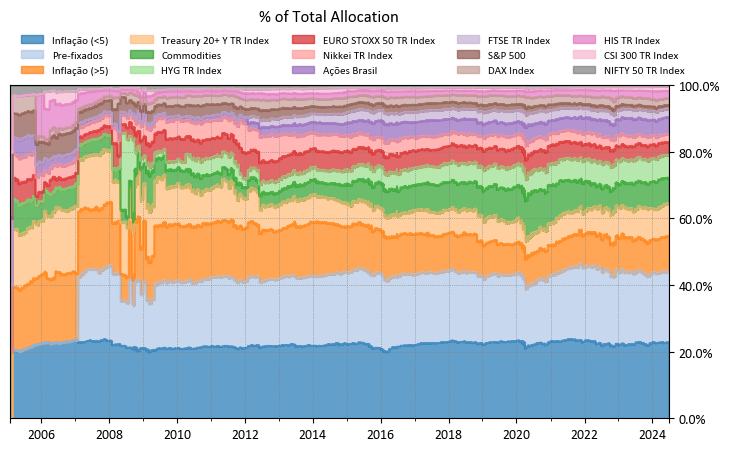

In [6]:


df_weights = pd.read_excel(
    r"C:\Users\pcampos\OneDrive - Insper - Instituto de Ensino e Pesquisa\Asset Allocation\Projeto\resultados\backtest_cap_weights.xlsx",
    index_col=0,
    usecols="A,AI:AW",
)
df_weights.columns = df_weights.columns.str.replace(".1", "")
df_weights = df_weights.divide(df_weights.sum(axis=1), axis=0)
df = df_weights.copy()
df = df[df.mean().sort_values(ascending=False).index]

stacked_bar_plot(
    df_weights,
    output_path=OUTPUT_FOLDER.joinpath("allocation_history.svg"),
)